# Predicting Electronic density of states N(E$_f$) Refractory High-Entropy Alloys using Machine Learning

In our recent studies, ( _https://doi.org/10.1016/j.matdes.2025.113885_, `Materials & Design, 2025`), the electronic density of states at the Fermi level (**N(E$_f$)**) has emerged as a powerful descriptor for predicting key mechanical properties of refractory high entropy alloys (RHEAs), such as **elastic modulus, bond stiffness, ductility**, and **local lattice distortion (LLD)**. However, calculating NN(E$_f$) typically requires expensive DFT simulations. In this notebook, we build a machine learning model that predicts N(Ef) directly from alloy composition, eliminating the need for computationally expensive electronic structure calculations. This capability enables rapid screening and design of new RHEAs with optimized properties, making the approach both time-efficient and impactful for accelerating materials discovery.

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
import math
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


# import ML models and metrices
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor

In [2]:
df = pd.read_excel('all_data_combined_ml_dos_enthaly_structure.xlsx')
df.head()

,Alloy,N(Ef),DH (eV),Structure
0,Cr100,0.6025,0.0,BCC
1,Mo100,0.5635,0.0,BCC
2,W100,0.4296,0.0,BCC
3,V100,1.9982,0.0,BCC
4,Nb100,1.8519,0.0,BCC


- The electronic density of states at the Fermi level (**N(E$_f$)**) is obtianed from first principle density functional theory calcualtions.
- The enthalpy change (DH) is calculated using the formula:

$$
\Delta H = E(\text{alloy}) - \sum E(\text{pure elements})
$$

#### Explanation

1. **E(alloy)**:
   - Represents the total energy of the alloy.
   - This value is typically negative.

2. **∑E(pure elements)**:
   - Represents the sum of the energies of the pure elements.
   - These values are also negative and stored in the `H_purSince both **E(alloy)** and **∑E(pure elements)** are negative, the subtraction reflects the relative stability of the alloy compared to its constituent pure elements.ent pure elements.
nt pure elements.


In [3]:
# Check duplicate alloys
duplicate_alloys = df[df['Alloy'].duplicated(keep=False)]

# Print duplicate alloy names
print("Number of duplicate alloy names:", duplicate_alloys.shape[0])
print("\nDuplicate alloy names:")
print(duplicate_alloys)

Number of duplicate alloy names: 0

Duplicate alloy names:
Empty DataFrame
Columns: [Alloy, N(Ef), DH (eV), Structure]
Index: []


 # Feature Engineering

## Creating Composition-Based Features
In this section, we generate several important chemical and thermodynamic features directly from the alloy compositions. These features serve as the input to our machine learning model, allowing us to predict Young’s modulus without relying on expensive DFT calculations.

We import custom feature-engineering functions from ML_functions.ipynb and apply them to each alloy:

## Elemental Percentages:
Extracts and adds individual elemental fractions as separate features. Serve as baseline compositional descriptors to capture the influence of individual elements.

These composition-based features form the foundation for training our ML model to predict elastic properties.

## Mixing Enthalpy:

Mixing Enthalpy Captures the energy change due to element interactions during alloy formation and influences phase stability and bond strength.

The mixing enthalpy is calculated using the following formula:
  $$
  \Delta H_{\text{mix}} = \sum_{i=1, i \neq j}^{n} 4H_{ij}C_iC_j
  $$
  where:
  - $C_i, C_j$: Molar percentages of elements $i$ and $j$.
  - $H_{ij}$: Interaction parameter (enthalpy of mixing) for the element pair $i$ and $j$.

- Iterates through all unique pairs of elements and calculates the contribution to the total enthalpy of mixing.

- 

## Valence Electron Concentration (VEC):
VEC is a key predictor of phase stability and mechanical properties. Strongly correlated with the phase type (e.g., BCC, FCC) and key mechanical properties like stiffness and ductility.

The Valence Electron Concentration (VEC) is calculated using the following formula:

$$
\text{VEC} = \sum_{i=1}^{n} C_i \cdot \text{VEC}_i
$$

Where:

- **$C_i$**: Atomic (molar) percentage of element $i$ in the alloy, normalized such that $\sum C_i = 1$ (or divided by 100 if input is in %)
- **$\text{VEC}_i$**: Valence electron count of element $i$
- **$n$**: Total number of elements in the alloy

This weighted average gives a single scalar value that reflects the average number of valence electrons per atom in the alloy — a useful descriptor for predicting phase stability and mechanical properties.

## Melting Temperature (MT)

The melting temperature is calculated as a weighted average of the constituent elements' melting points, serving as an indicator of thermal stability and bonding characteristics.

Melting Temperature (MT) is calculated using the following formula:

$$
\text{MT} = \frac{\sum_{i=1}^{n} C_i \cdot T_i}{100}
$$

**Parameters:**
- $C_i$: Atomic percentage of element $i$ (0-100%)
- $T_i$: Melting point of element $i$ (in Kelvin)
- $n$: Number of elements in the alloy


## Pauling electronegativity: 
It is an averageselectronegativity difference among alloying elements. Differences in electronegativity between elements affect charge transfer and bond character.

Pauling Electronegativity is calculated using the following formula:

$$
\chi = \frac{\sum_{i=1}^{n} (C_i \cdot \chi_i)}{100}
$$

Where:
- $\chi_i$ = Pauling electronegativity of element $i$  
- $C_i$ = Atomic percentage of element $i$  
- $n$ = Number of elements in the alloy

Components:
1. The sum ($\sum$) runs over all elements ($i = 1$ to $n$)
2. Each element's contribution is its percentage ($C_i$) multiplied by its electronegativity ($\chi_i$)
3. The total is divided by 100 to convert from percentage to fraction

## Entropy of Mixing:
Configurational entropy assuming ideal mixing. Represents the configurational randomness in the alloy and plays a crucial role in stabilizing single-phase solid solutions.

Entropy of Mixing (ΔS<sub>mix</sub>) is calculated using the following formula:

$$
\Delta S_{mix} = -R \sum_{i=1}^{n} (x_i \cdot \ln x_i)
$$

 Where:
- $R$ = Gas constant (8.314 J/mol·K)
- $x_i$ = Molar fraction of element $i$ ($x_i = C_i/100$)
- $n$ = Number of elements in the alloy

**Key Points:**
- The natural log (ln) requires $x_i > 0$
- Summation runs over all elements in the alloy
- Negative sign ensures positive entropy for mixing
- Units: Joules per mole-Kelvin (J/mol·K)


## Radii difference (δ)

The atomic size difference (δ) is calculated using the following formula:

$$
\delta = \sum_{i=1}^{n} C_i \left( 1 - \frac{r_i}{\bar{r}} \right)^2
$$

where:
- $C_i$ is the atomic percentage of element $i$,
- $r_i$ is the atomic radius of element $i$,
- $\bar{r}$ is the average atomic radius of the alloy.
properties of alloys.


# Fuctions to create new: Thermodynamical and compostional features

In [4]:

# ----- Input data -----

# Mixing enthalpy values for AB pairs
AB_mix_enthalpy = {
    'Cr-Mo': 0, 'Cr-W': 1, 'Cr-V': -2, 'Cr-Nb': -7, 'Cr-Ta': -7, 'Cr-Ti': -7,
    'Cr-Zr': -12, 'Cr-Hf': -9, 'Mo-W': 0, 'Mo-V': 0, 'Mo-Nb': -6, 'Mo-Ta': -5,
    'Mo-Ti': -4, 'Mo-Zr': -6, 'Mo-Hf': -4, 'W-V': -1, 'W-Nb': -8, 'W-Ta': -7,
    'W-Ti': -6, 'W-Zr': -9, 'W-Hf': -6, 'V-Nb': -1, 'V-Ta': -1, 'V-Ti': -2,
    'V-Zr': -4, 'V-Hf': -2, 'Nb-Ta': 0, 'Nb-Ti': 2, 'Nb-Zr': 4, 'Nb-Hf': 4,
    'Ta-Ti': 1, 'Ta-Zr': 3, 'Ta-Hf': 3, 'Ti-Zr': 0, 'Ti-Hf': 0, 'Zr-Hf': 0
}

# Elements list
elements = ['Cr', 'Mo', 'W', 'V', 'Nb', 'Ta', 'Ti', 'Zr', 'Hf']

# Valence electron concentration values
pvec = {'Cr': 6, 'Mo': 6, 'W': 6, 'V': 5, 'Nb': 5, 'Ta': 5, 'Ti': 4, 'Hf': 4, 'Zr': 4}

# Melting temperatures (°C)  <-- values are in Celsius (not Kelvin)
mt = {'Cr': 1907, 'Mo': 2623, 'W': 3422, 'V': 1910, 'Nb': 2477, 'Ta': 3017, 'Ti': 1668, 'Zr': 1852, 'Hf': 2233}

# Pauling electronegativity values
chi = {'Cr': 1.66, 'Mo': 2.16, 'W': 2.36, 'V': 1.63, 'Nb': 1.6, 'Ta': 1.5, 'Ti': 1.54, 'Zr': 1.33, 'Hf': 1.3}

# Metallic radii (Å)
metallic_radius = {'Cr': 1.28,'Mo': 1.39, 'W': 1.39, 'V': 1.34, 'Nb': 1.46, 'Ta': 1.46, 'Ti': 1.47, 'Zr': 1.60, 'Hf': 1.59 }

# ----- Validator -----

def _require_props(percentages, prop_dict, prop_name):
    """Raise if any element in 'percentages' is missing from 'prop_dict'."""
    missing = [el for el in percentages if el not in prop_dict]
    if missing:
        raise KeyError(f"{prop_name} missing for elements: {missing}")

# ----- Functions -----

def parse_atomic_percentages(composition):
    """
    Parses the composition to extract elements and their atomic percentages.
    """
    matches = re.findall(r'([A-Z][a-z]*)(\d*\.?\d+|\d+)', composition)
    elements_local = [element for element, _ in matches]
    percentages = [float(percentage) for _, percentage in matches]

    total_percentage = sum(percentages)
    if not (99 <= total_percentage <= 101):
        raise ValueError(
            f"The total atomic percentage for {composition} is {total_percentage}%, "
            "which is outside the allowed range [99%, 101%]."
        )

    if abs(total_percentage - 100) > 1e-6:
        scaling_factor = 100 / total_percentage
        percentages = [p * scaling_factor for p in percentages]

    return dict(zip(elements_local, percentages))

def calculate_element_percentages(alloy):
    """
    Extracts the atomic percentages for each element from the composition.
    """
    percentages = parse_atomic_percentages(alloy)
    for element in elements:
        if element not in percentages:
            percentages[element] = 0.0
    return percentages

def calculate_mixing_enthalpy(composition, enthalpy_dict):
    """
    Calculate the mixing enthalpy for a composition using atomic percentages.
    (Kept exactly as you wrote it.)
    """
    percentages = parse_atomic_percentages(composition)
    elements_local = list(percentages.keys())
    n = len(elements_local)
    total_enthalpy = 0

    for i in range(n):
        for j in range(i + 1, n):
            pair = f"{elements_local[i]}-{elements_local[j]}"
            reverse_pair = f"{elements_local[j]}-{elements_local[i]}"
            interaction = enthalpy_dict.get(pair, enthalpy_dict.get(reverse_pair, 0))
            total_enthalpy += 4 * (percentages[elements_local[i]] / 100) * (percentages[elements_local[j]] / 100) * interaction

    return total_enthalpy

def calculate_vec(composition, pvec):
    """
    Weighted average VEC (dimensionless).
    """
    percentages = parse_atomic_percentages(composition)
    _require_props(percentages, pvec, "VEC map")
    vec_sum = sum(percentages[element] * pvec[element] for element in percentages)
    vec_sum /= 100
    return vec_sum

def calculate_mt(composition, mt):
    """
    Weighted average melting temperature from values in °C (returns °C).
    If you need Kelvin, add 273.15 to the result outside this function.
    """
    percentages = parse_atomic_percentages(composition)
    _require_props(percentages, mt, "Melting temperature map")
    mt_sum = sum(percentages[element] * mt[element] for element in percentages)
    mt_sum /= 100
    return mt_sum

def calculate_pauli(composition, chi):
    """
    Weighted average Pauling electronegativity.
    """
    percentages = parse_atomic_percentages(composition)
    _require_props(percentages, chi, "Pauling electronegativity map")
    pauli_sum = sum(percentages[element] * chi[element] for element in percentages)
    pauli_sum /= 100
    return pauli_sum

def calculate_entropy_of_mixing(composition):
    """
    ΔSmix = -R Σ (Ci ln Ci), Ci as fractions. Returns J/(mol·K).
    """
    percentages = parse_atomic_percentages(composition)
    molar_fractions = [percentage / 100 for percentage in percentages.values()]
    R = 8.314
    smix = -R * sum(mf * math.log(mf) for mf in molar_fractions if mf > 0)
    return smix

def calculate_atomic_size_difference(composition, metallic_radius):
    """
    δ = sqrt( Σ_i w_i (1 - r_i / r̄)^2 ), w_i are atomic fractions.
    """
    atomic_percentages = parse_atomic_percentages(composition)
    _require_props(atomic_percentages, metallic_radius, "Metallic radius map")

    total_percentage = sum(atomic_percentages.values())
    average_radius = sum(
        atomic_percentages[element] * metallic_radius[element]
        for element in atomic_percentages
    ) / total_percentage

    delta_squared = sum(
        atomic_percentages[element] * (1 - (metallic_radius[element] / average_radius)) ** 2
        for element in atomic_percentages
    ) / total_percentage  # normalize: use fractions, not % weights

    delta = math.sqrt(delta_squared)
    return delta


In [5]:
## TEST imported functions
composition = 'W20Nb20Mo20Ta20V20'

# Calculate mixing enthalpy
mixing_enthalpy = calculate_mixing_enthalpy(composition, AB_mix_enthalpy)
print(f"Mixing Enthalpy: {mixing_enthalpy} kJ/mol")

Mixing Enthalpy: -4.640000000000001 kJ/mol


In [6]:
## TEST imported functions
composition = "Ta20Nb20Hf20Zr20Ti20"
delta = calculate_atomic_size_difference(composition, metallic_radius)
print(f"Atomic size difference (δ) for {composition}: {delta:.4f}")

Atomic size difference (δ) for Ta20Nb20Hf20Zr20Ti20: 0.0427


In [7]:
# Using imported functions to create new features

# Mixing enthalpy
df['Mixing Enthalpy'] = df['Alloy'].apply(lambda x: calculate_mixing_enthalpy(x, AB_mix_enthalpy))

# VEC
df['VEC'] = df['Alloy'].apply(lambda x: calculate_vec(x, pvec))

# Melting temperature
df['Melting Temperature'] = df['Alloy'].apply(lambda x: calculate_mt(x, mt))

# Electronegativity
df['Pauling Electronegativity'] = df['Alloy'].apply(lambda x: calculate_pauli(x, chi))

# Entropy of mixing
df['Entropy of Mixing'] = df['Alloy'].apply(calculate_entropy_of_mixing)

# Atomic mismatch
df['Radii Difference'] =df['Alloy'].apply(lambda x: calculate_atomic_size_difference(x, metallic_radius))

# Apply the function and expand the result into new columns
percentages_df = df['Alloy'].apply(lambda x: calculate_element_percentages(x)).apply(pd.Series)
df = pd.concat([df, percentages_df], axis=1)

In [8]:
df.head()

,Alloy,N(Ef),DH (eV),Structure,Mixing Enthalpy,VEC,Melting Temperature,Pauling Electronegativity,Entropy of Mixing,Radii Difference,Cr,Mo,W,V,Nb,Ta,Ti,Zr,Hf
0,Cr100,0.6025,0.0,BCC,0.0,6.0,1907.0,1.66,-0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Mo100,0.5635,0.0,BCC,0.0,6.0,2623.0,2.16,-0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,W100,0.4296,0.0,BCC,0.0,6.0,3422.0,2.36,-0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
3,V100,1.9982,0.0,BCC,0.0,5.0,1910.0,1.63,-0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
4,Nb100,1.8519,0.0,BCC,0.0,5.0,2477.0,1.60,-0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0


In [9]:
df.columns

Index(['Alloy', 'N(Ef)', 'DH (eV)', 'Structure', 'Mixing Enthalpy', 'VEC',
       'Melting Temperature', 'Pauling Electronegativity', 'Entropy of Mixing',
       'Radii Difference', 'Cr', 'Mo', 'W', 'V', 'Nb', 'Ta', 'Ti', 'Zr', 'Hf'],
      dtype='object')

In [10]:
df.shape

(460, 19)

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
N(Ef),460.0,1.277072,0.290723,0.429600,1.167025,1.337250,1.463950,1.998200
DH (eV),460.0,0.226144,2.859447,-7.829882,-1.809461,0.117728,2.293445,10.792700
Mixing Enthalpy,460.0,-3.269122,2.551093,-9.000000,-5.000000,-3.680000,-1.720000,4.000000
VEC,460.0,5.014348,0.396027,4.100000,4.750000,5.000000,5.300000,6.000000
Melting Temperature,460.0,2391.776174,270.333112,1772.760000,2192.030000,2395.410000,2576.375000,3422.000000
Pauling Electronegativity,460.0,1.701666,0.165730,1.381000,1.574500,1.686750,1.821250,2.360000
Entropy of Mixing,460.0,10.490480,2.186984,-0.000000,9.713100,10.958644,11.793273,13.380867
Radii Difference,460.0,0.052897,0.018719,0.000000,0.041648,0.053535,0.065031,0.103881
Cr,460.0,7.193478,14.142427,0.000000,0.000000,0.000000,10.000000,100.000000
Mo,460.0,13.476087,16.713447,0.000000,0.000000,5.000000,25.000000,100.000000


In [12]:
df.isnull().any()

Alloy                        False
N(Ef)                        False
DH (eV)                      False
Structure                    False
Mixing Enthalpy              False
VEC                          False
Melting Temperature          False
Pauling Electronegativity    False
Entropy of Mixing            False
Radii Difference             False
Cr                           False
Mo                           False
W                            False
V                            False
Nb                           False
Ta                           False
Ti                           False
Zr                           False
Hf                           False
dtype: bool

 # Select only BCC alloys

In [13]:
# Select only BCC structures
# df= df[df['Structure']=='BCC']

df.head()

,Alloy,N(Ef),DH (eV),Structure,Mixing Enthalpy,VEC,Melting Temperature,Pauling Electronegativity,Entropy of Mixing,Radii Difference,Cr,Mo,W,V,Nb,Ta,Ti,Zr,Hf
0,Cr100,0.6025,0.0,BCC,0.0,6.0,1907.0,1.66,-0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Mo100,0.5635,0.0,BCC,0.0,6.0,2623.0,2.16,-0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,W100,0.4296,0.0,BCC,0.0,6.0,3422.0,2.36,-0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
3,V100,1.9982,0.0,BCC,0.0,5.0,1910.0,1.63,-0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
4,Nb100,1.8519,0.0,BCC,0.0,5.0,2477.0,1.60,-0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0


In [14]:
df.shape

(460, 19)

In [15]:
df.to_csv('final_df_all_bcc.csv', index=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Alloy                      460 non-null    object 
 1   N(Ef)                      460 non-null    float64
 2   DH (eV)                    460 non-null    float64
 3   Structure                  460 non-null    object 
 4   Mixing Enthalpy            460 non-null    float64
 5   VEC                        460 non-null    float64
 6   Melting Temperature        460 non-null    float64
 7   Pauling Electronegativity  460 non-null    float64
 8   Entropy of Mixing          460 non-null    float64
 9   Radii Difference           460 non-null    float64
 10  Cr                         460 non-null    float64
 11  Mo                         460 non-null    float64
 12  W                          460 non-null    float64
 13  V                          460 non-null    float64

In [16]:
## No null values above !!

In [17]:
feature_columns =['Mixing Enthalpy', 'VEC', 'Melting Temperature', 'Pauling Electronegativity', 'Entropy of Mixing', 'Radii Difference',
                  'Cr', 'Mo', 'W', 'V', 'Nb', 'Ta', 'Ti', 'Zr', 'Hf' ] 

X=df[feature_columns]
y=df['N(Ef)']
X.shape

(460, 15)

# Data analysis

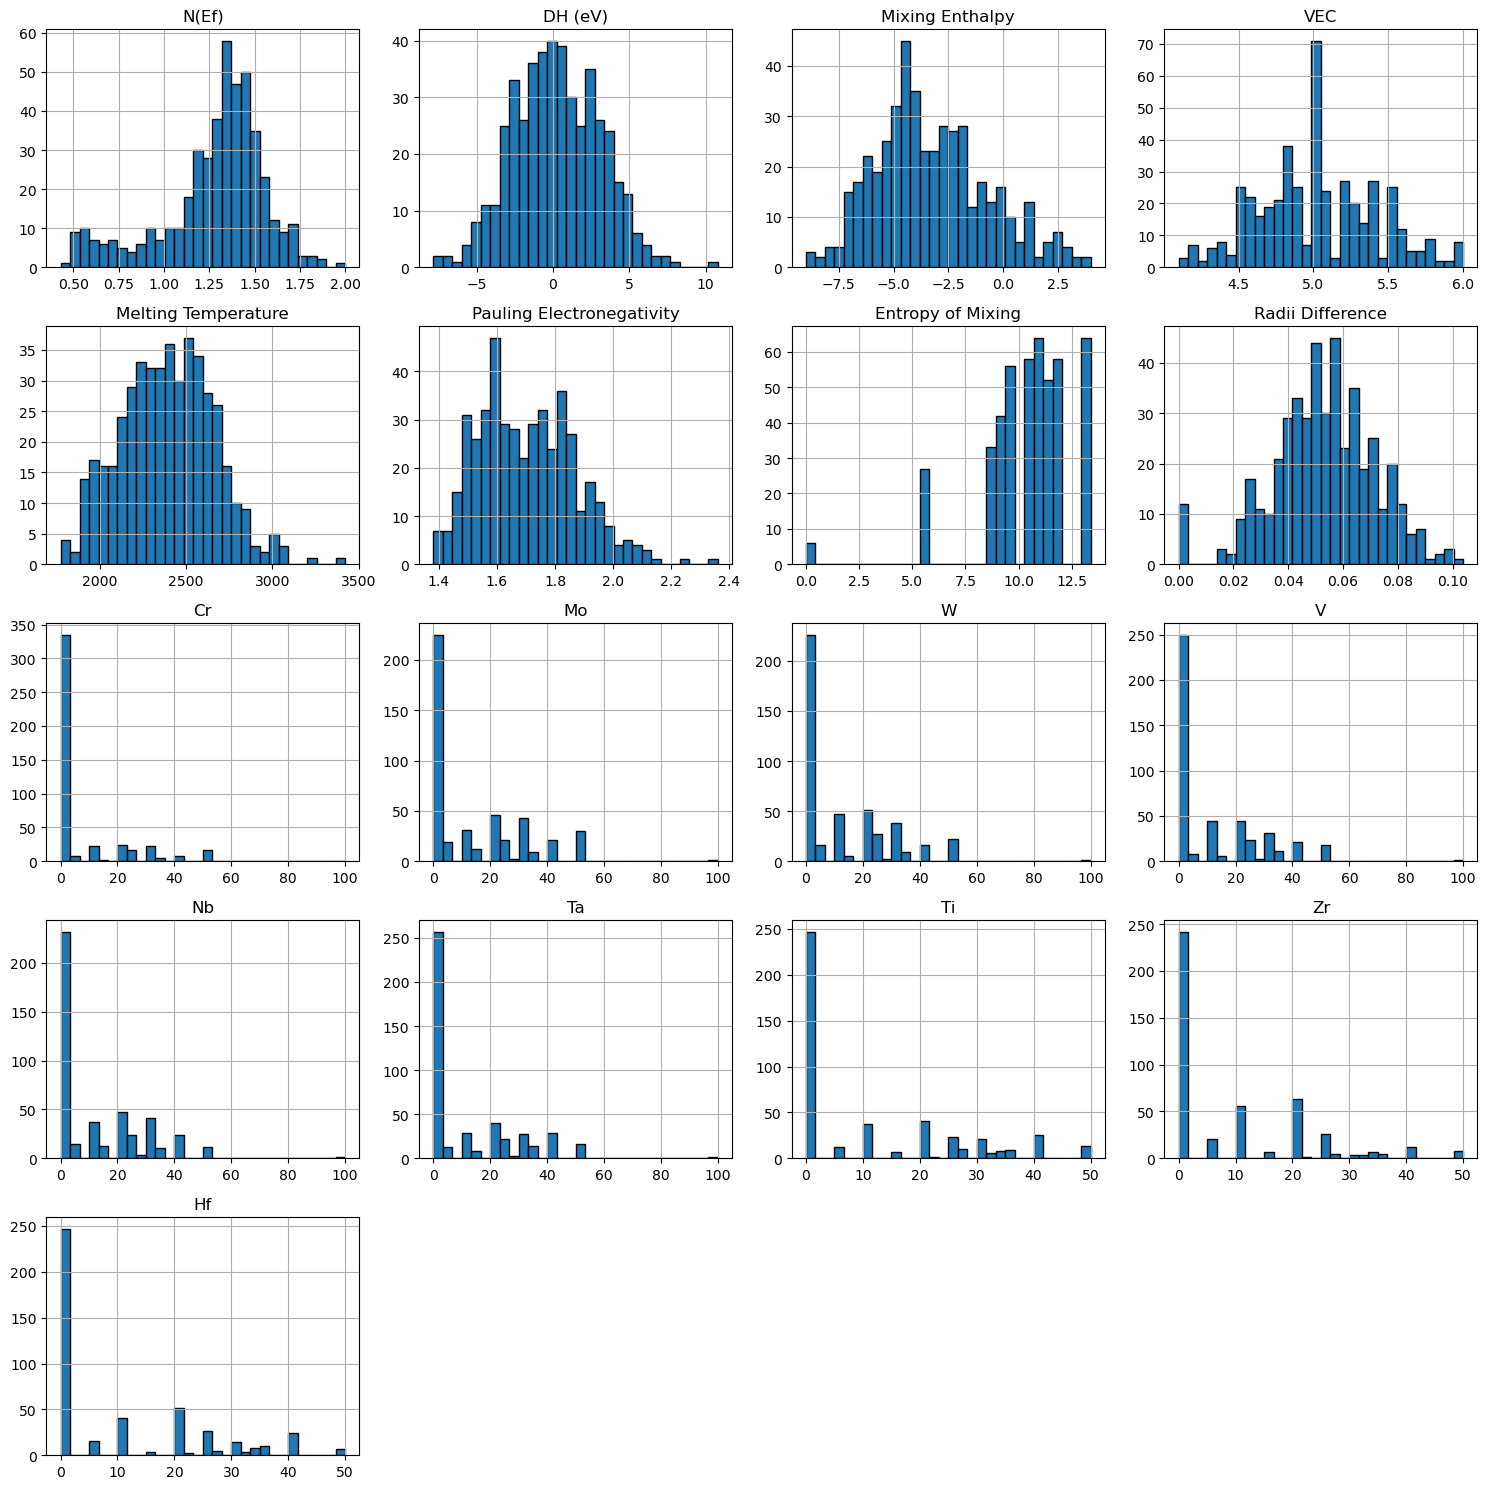

In [18]:
# plot histogram of each feature
df.hist(figsize = (15, 15), bins= 30, edgecolor = 'black')
plt.tight_layout()
plt.show()

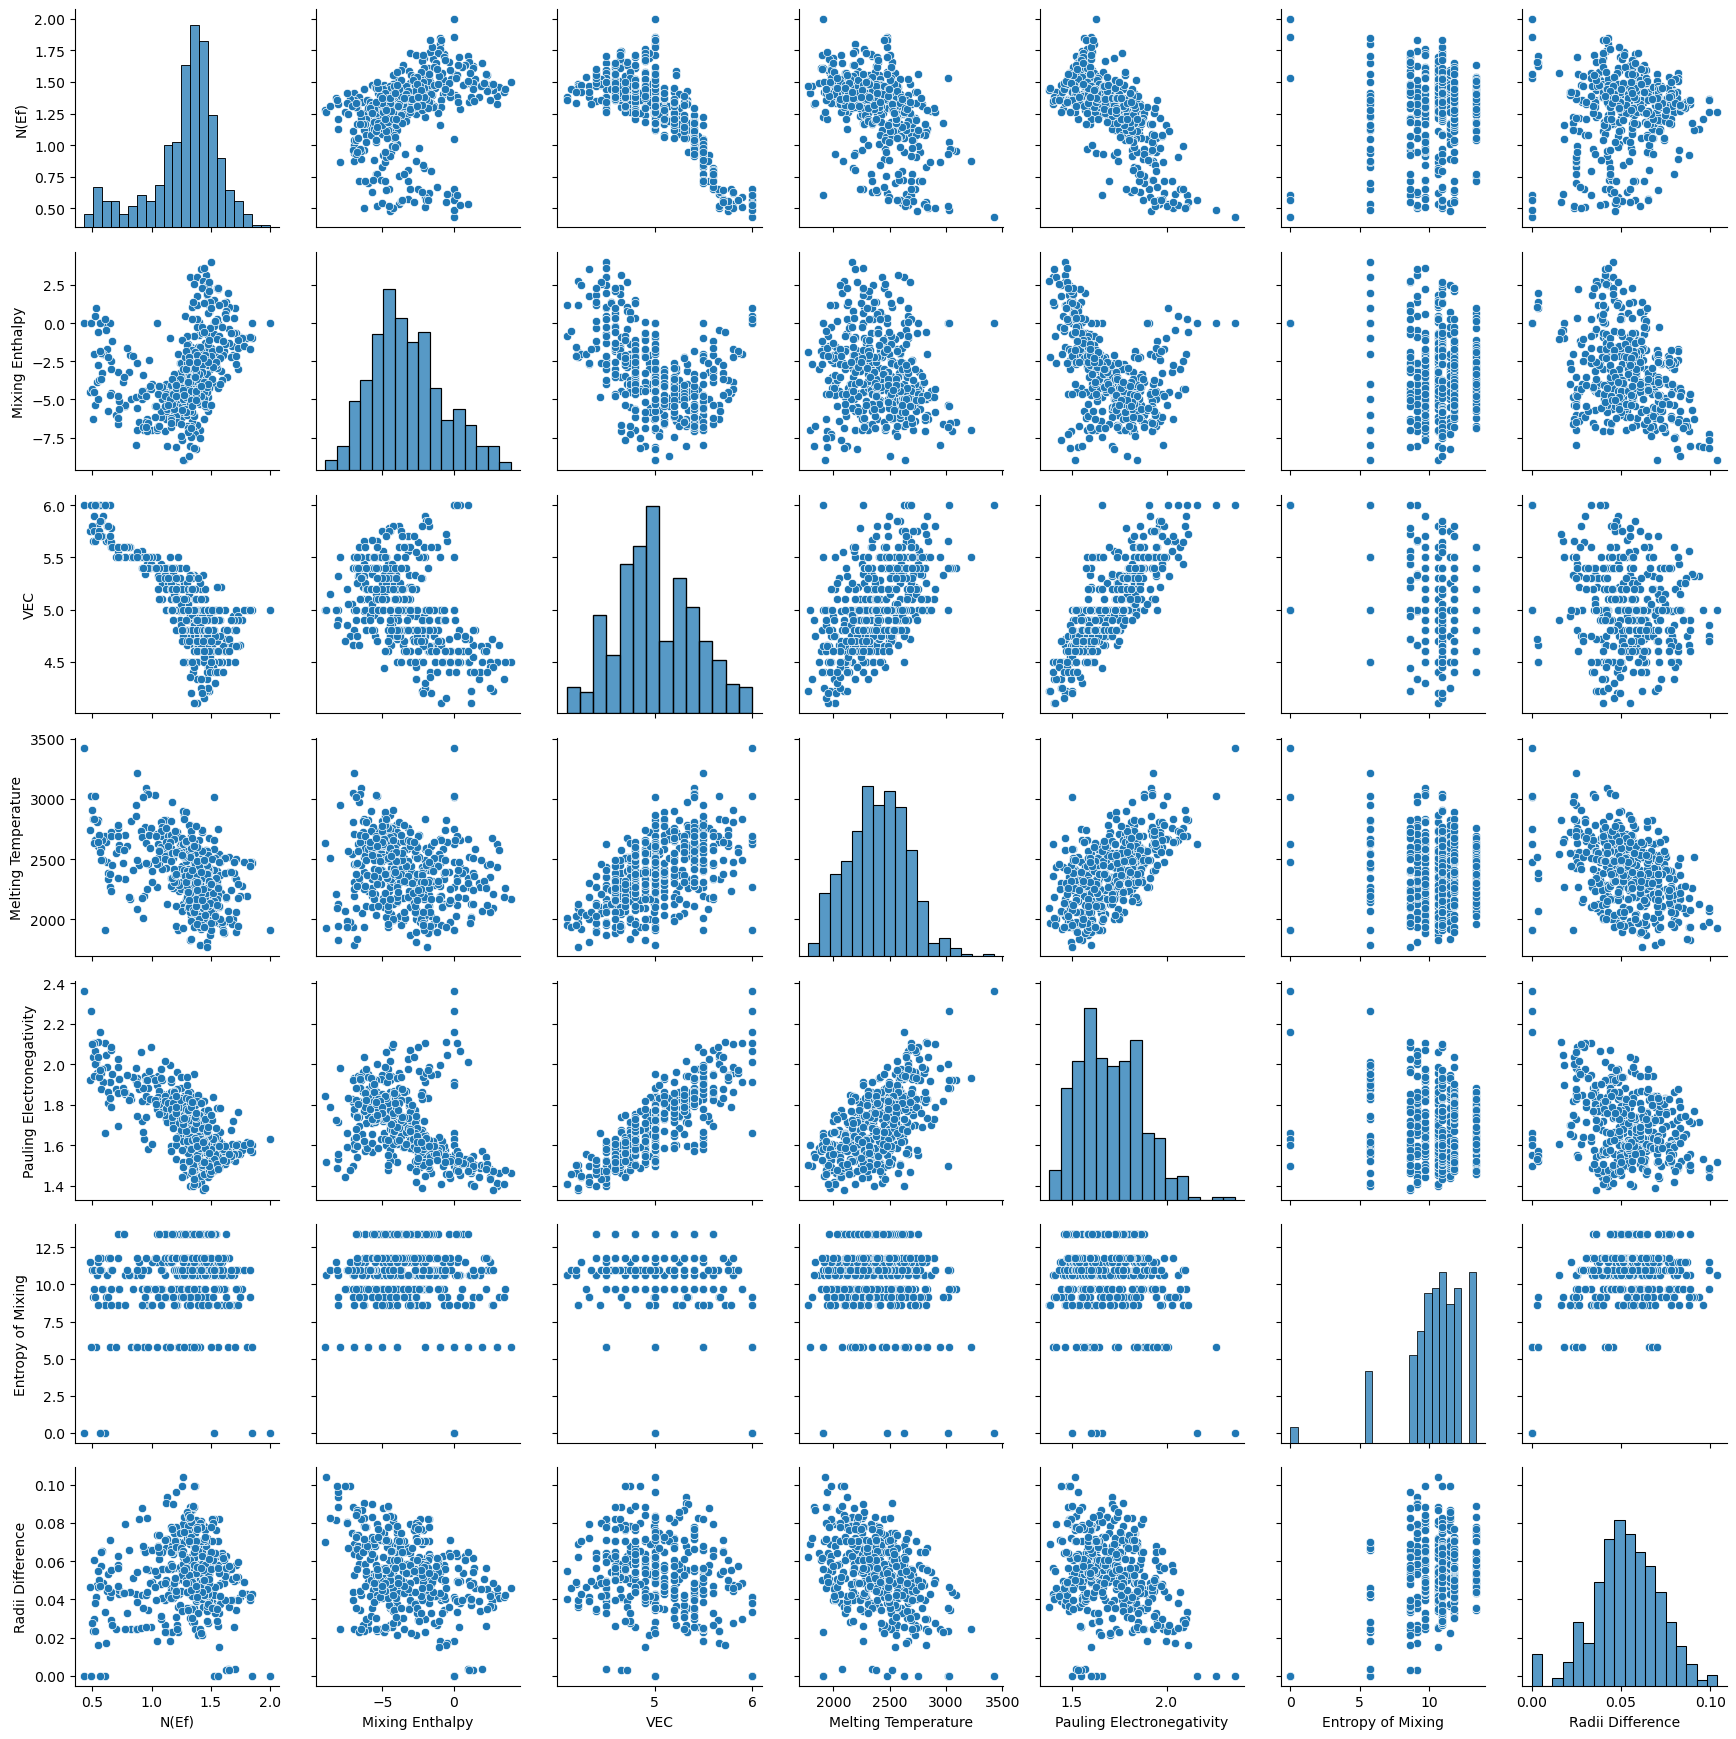

In [19]:
# plt.figure(figsize=(8,8))
sns.pairplot(df[['N(Ef)','Mixing Enthalpy', 'VEC', 'Melting Temperature', 'Pauling Electronegativity', 'Entropy of Mixing', 'Radii Difference']])  
plt.tight_layout()
plt.show()

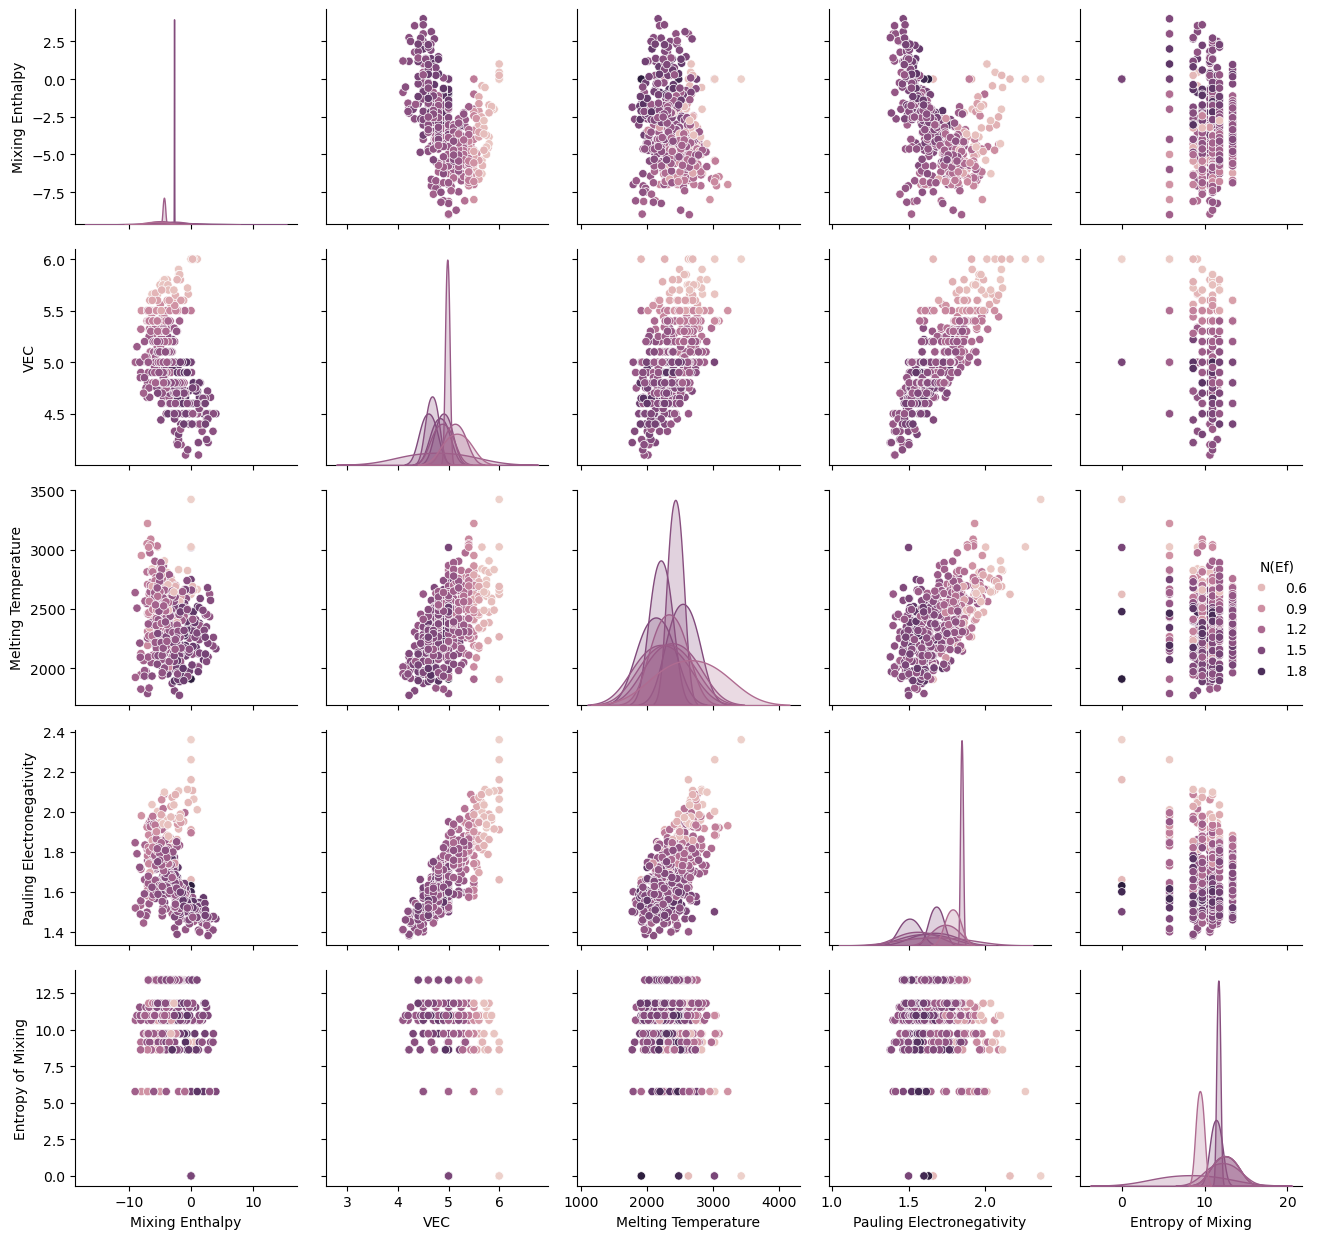

In [20]:
sns.pairplot(df[['N(Ef)','Mixing Enthalpy', 'VEC', 'Melting Temperature', 'Pauling Electronegativity', 'Entropy of Mixing']], hue='N(Ef)')  # Replace 'target_column' with the name of your categorical column
plt.tight_layout()
plt.show()

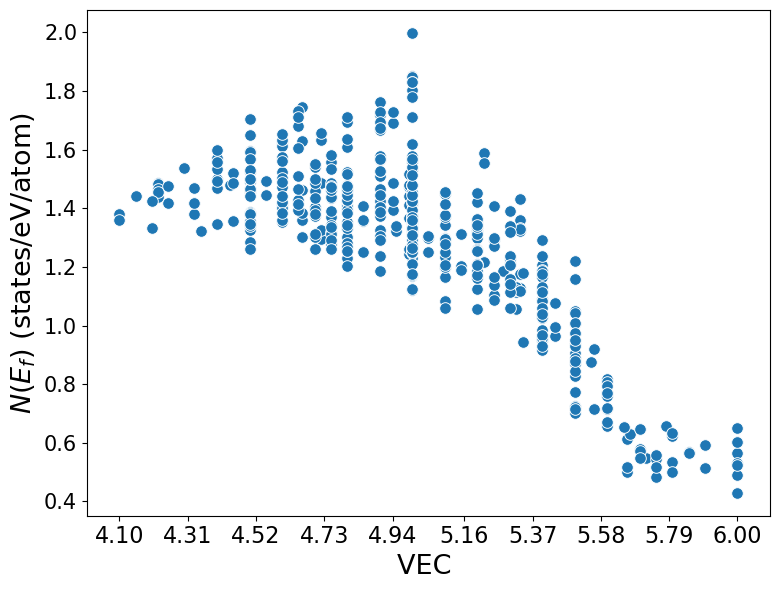

In [21]:

#---- style / sizing ----
FIGSIZE = (7.9, 6)   # inches
DPI = 300
COLOR = "#999999"  # medium gray

plt.figure(figsize=FIGSIZE)
sns.scatterplot(x='VEC', y='N(Ef)', data=df, s=70)

# for paper
# sns.scatterplot(
#     x="VEC", y="N(Ef)", data=df, s=115,
#     color=COLOR, edgecolor="white", linewidth=0.6
# )



# labels & fonts
plt.xlabel("VEC ", fontsize=19.5)
plt.ylabel(r"$N(E_f)$ (states/eV/atom)", fontsize=19.5)

# custom x-ticks to match your figure
ticks = [4.10, 4.31, 4.52, 4.73, 4.94, 5.16, 5.37, 5.58, 5.79, 6.00]
plt.xticks(ticks, [f"{t:.2f}" for t in ticks], fontsize=16)
plt.xlim(4, 6.1)  # slight padding so first/last tick are visible

# y-ticks
plt.yticks(fontsize=15)



plt.tight_layout()
plt.savefig("Fig_1a-new.png", dpi=300, bbox_inches="tight")
plt.show()


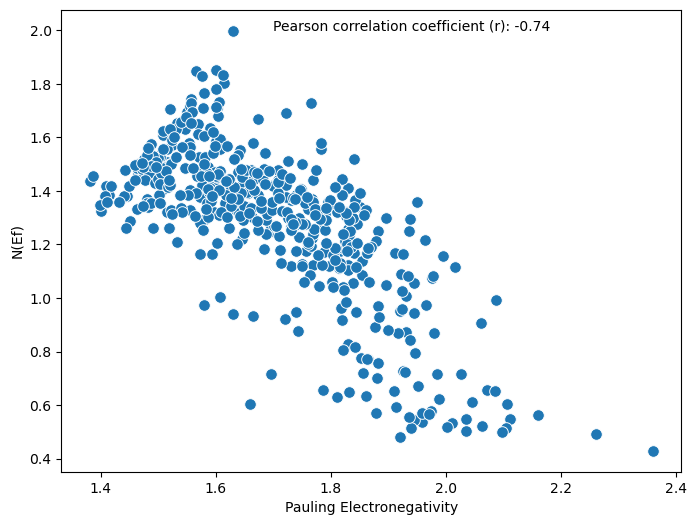

In [22]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Pauling Electronegativity', y='N(Ef)', data=df, s=70)
r = np.corrcoef( df['Pauling Electronegativity'], df['N(Ef)'])[0, 1]
plt.text(1.7, 2, f'Pearson correlation coefficient (r): {r:.2f}')

plt.xticks()
plt.show()


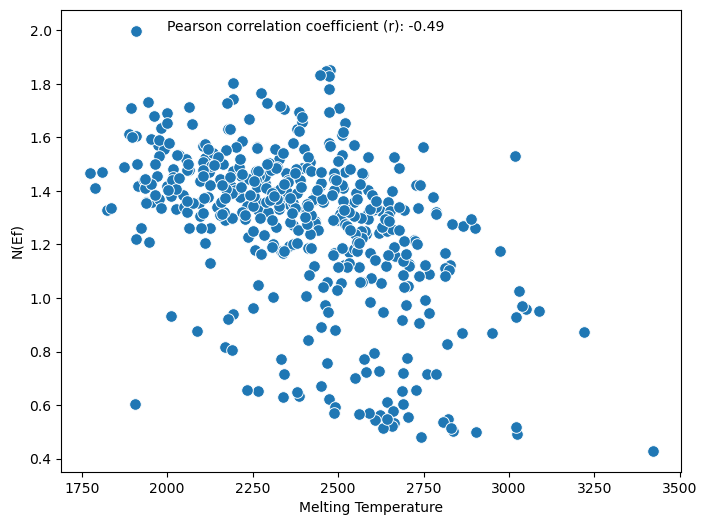

In [23]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Melting Temperature', y='N(Ef)', data=df, s=70)
r = np.corrcoef( df['Melting Temperature'], df['N(Ef)'])[0, 1]
plt.text(2000, 2, f'Pearson correlation coefficient (r): {r:.2f}')

plt.xticks()
plt.show()


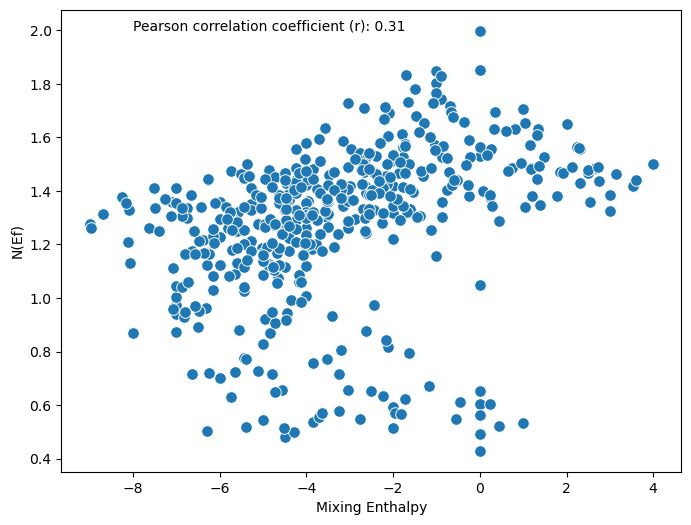

In [24]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Mixing Enthalpy', y='N(Ef)', data=df, s=70)
r = np.corrcoef( df['Mixing Enthalpy'], df['N(Ef)'])[0, 1]
plt.text(-8, 2, f'Pearson correlation coefficient (r): {r:.2f}')

plt.xticks()
plt.show()


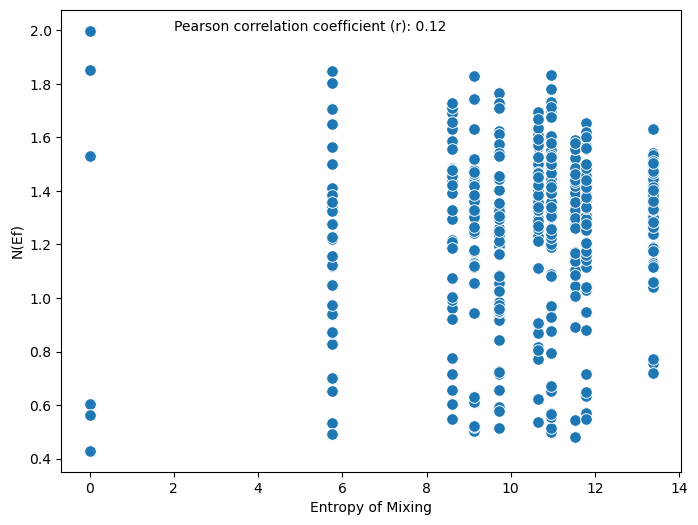

In [25]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Entropy of Mixing', y='N(Ef)', data=df, s=70)
r = np.corrcoef( df['Entropy of Mixing'], df['N(Ef)'])[0, 1]
plt.text(2, 2, f'Pearson correlation coefficient (r): {r:.2f}')

plt.xticks()
plt.show()

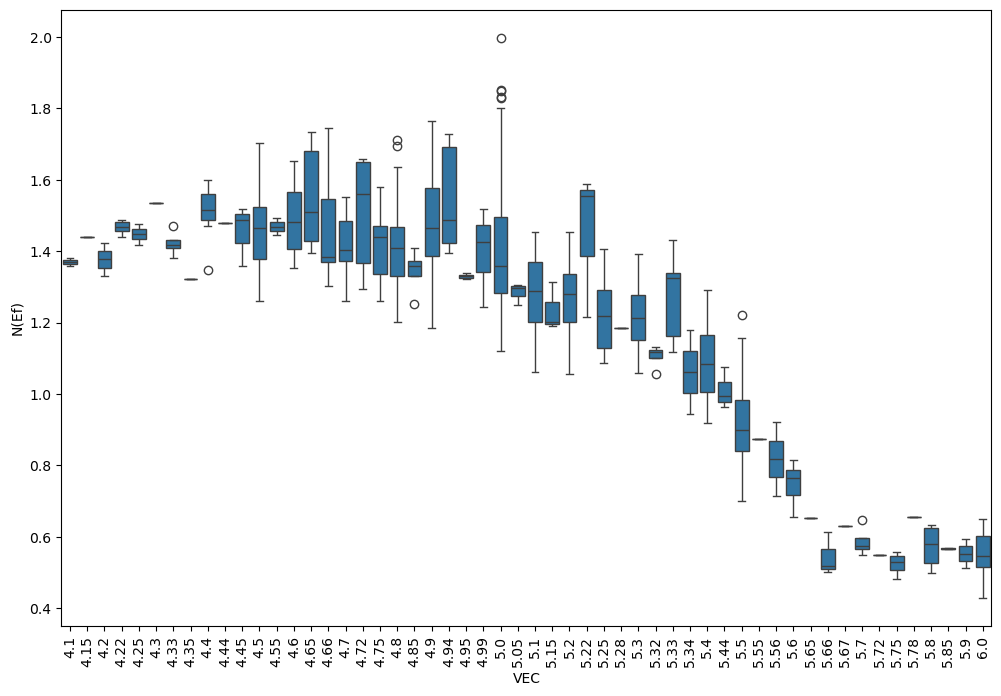

In [26]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='VEC', y='N(Ef)', data=df)
plt.xticks(rotation =90)
plt.show()


Even when VEC is fixed, N(E<sub>f</sub>) varies significantly due to differences in alloy chemistry and bonding. This reinforces that N(E<sub>f</sub>), which capture all electronic interactions, is a more precise and sensitive descriptor for understanding and predicting alloy behavior than VEC alone.

The points flagged as "outliers" by the boxplot are not necessarily errors in materials science. In fact, they may reveal chemically or electronically unique alloy configurations. Rather than discarding them, they should be examined more closely—they might hold the key to discovering non-intuitive behavior or novel materials.

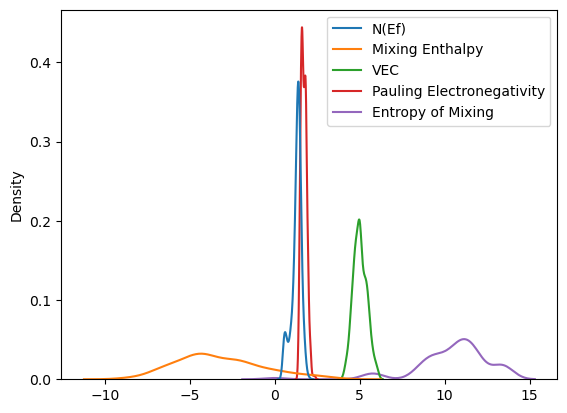

In [27]:
sns.kdeplot(data =df[['N(Ef)','Mixing Enthalpy', 'VEC',  'Pauling Electronegativity', 'Entropy of Mixing']])
plt.show()

The KDE plot above shows the distribution of key descriptors for refractory alloys: N(Ef), Mixing Enthalpy, Valence Electron Concentration (VEC), Pauling Electronegativity, and Entropy of Mixing. N(Ef), VEC, and Electronegativity display narrow, sharp peaks, indicating limited variation across the refractory alloy dataset, likely due to the similar electronic structure and valence configuration of refractory elements. In contrast, Mixing Enthalpy and Entropy of Mixing exhibit broader distributions, reflecting greater diversity in atomic interactions and compositional complexity. These trends highlight that while electronic descriptors remain relatively stable in refractory systems, thermodynamic properties introduce more variation and may better capture differences in alloy behavior.

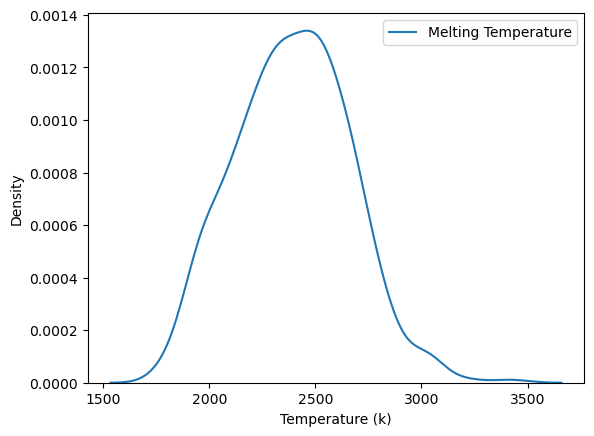

In [28]:
sns.kdeplot(data =df[['Melting Temperature']])
plt.xlabel( 'Temperature (k)')
plt.show()

The KDE plot above shows the distribution of melting temperatures for a set of refractory alloys. The curve peaks around 2400–2500 K, indicating that most alloys in the dataset have melting temperatures in this range. The distribution is moderately skewed to the right, with a long tail extending beyond 3000 K, reflecting the presence of a few ultra-high-temperature alloys. This trend is consistent with the high thermal stability characteristic of refractory materials, which typically include elements like Mo, W, Ta, and Nb. The overall spread suggests a broad design space in terms of thermal resistance within the studied alloys.

## Correlations between the input features: Heatmap matix

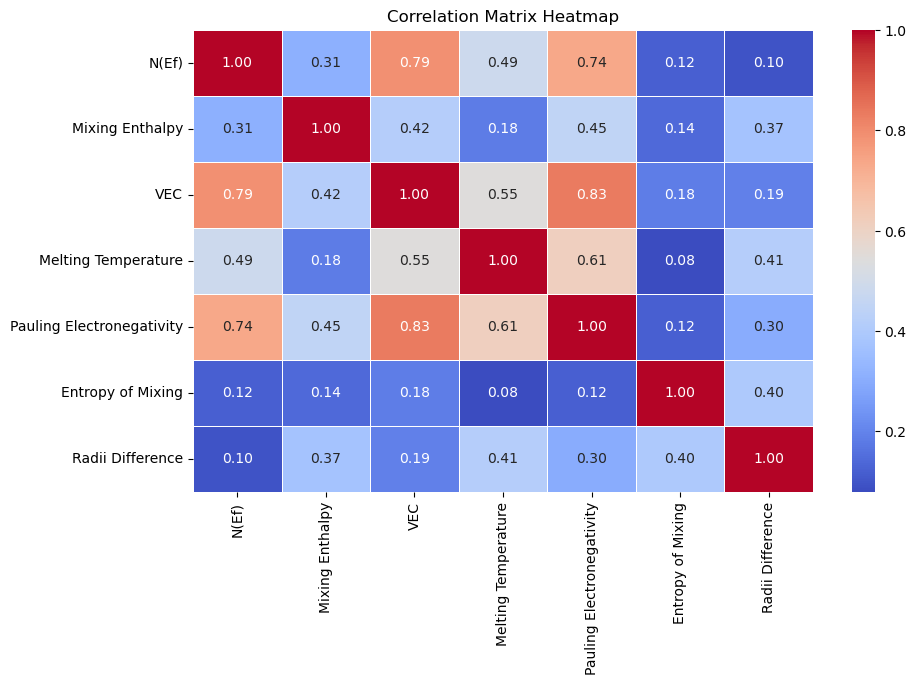

In [29]:
cor_feature =['N(Ef)','Mixing Enthalpy', 'VEC', 'Melting Temperature', 'Pauling Electronegativity', 'Entropy of Mixing', 'Radii Difference']
Cr = df[cor_feature]
plt.figure(figsize=(10,6))
sns.heatmap(Cr.corr().abs(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()
          

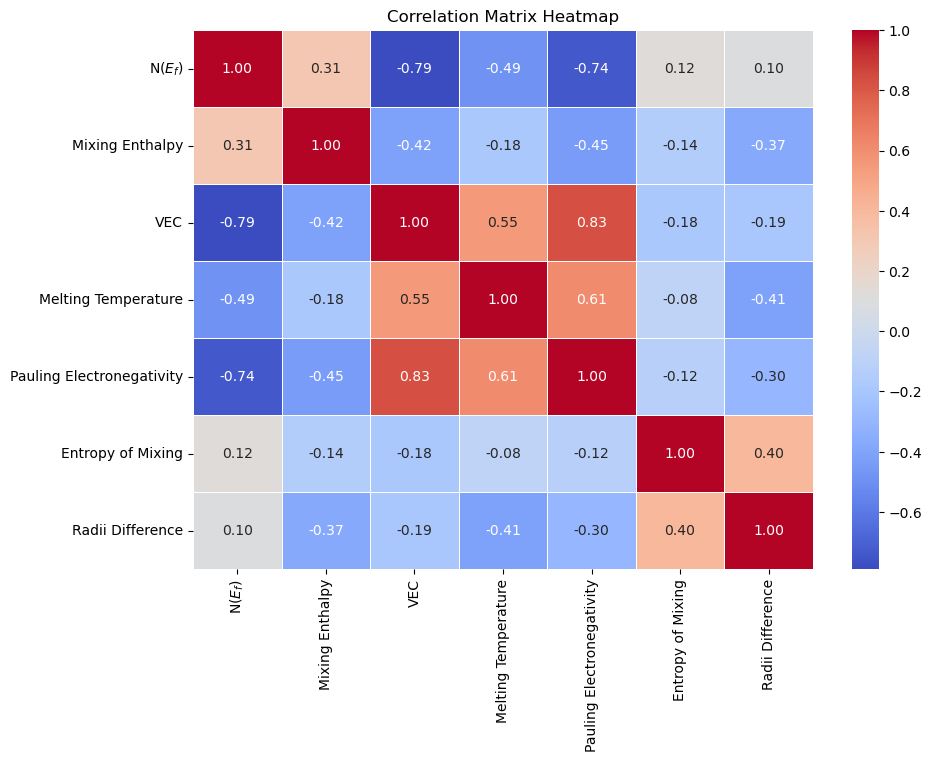

In [30]:
cor_feature = ['N(Ef)', 'Mixing Enthalpy', 'VEC', 'Melting Temperature', 
               'Pauling Electronegativity', 'Entropy of Mixing', 'Radii Difference']

Cr = df[cor_feature]
corr = Cr.corr()

# Rename columns/rows for LaTeX formatting
corr = corr.rename(index={"N(Ef)": r"N$(E_{f})$"},
                   columns={"N(Ef)": r"N$(E_{f})$"})

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


**Note:** Some of the input features in this dataset are highly correlated. While multicollinearity can be problematic for linear models by inflating coefficient variance, it is less of a concern for **tree-based models**, which are generally robust to redundant features. In the case of linear models, techniques like **Ridge regression** (L2 regularization) and **Lasso regression** (L1 regularization) can be used to mitigate this issue by penalizing large coefficients and performing feature selection. In this project, we will monitor model performance closely and apply appropriate regularization or feature selection techniques as needed to ensure both accuracy and stability.

In [31]:

# Define the Young’s modulus (E_VRH) dictionary
evrh = {
    "Cr": 279, "Mo": 329, "W": 382, "V": 130, "Nb": 105, "Ta": 186, 
    "Ti": 116, "Hf": 78, "Zr": 88, "Re": 450, "Ru": 480
}


def calculate_weighted_evrh(composition, evrh):
    """
    Calculate the weighted average Young’s modulus (E_VRH) for the alloy.

    Args:
        composition (str): The alloy composition.
        evrh (dict): A dictionary of E_VRH values for each element.

    Returns:
        float: Weighted average Young’s modulus (E_VRH).
    """
    percentages = parse_atomic_percentages(composition)

    # Compute weighted Young’s modulus
    evrh_sum = sum(percentage * evrh.get(element, 0) for element, percentage in percentages.items())
    return evrh_sum / 100  # Normalize by 100

# Calculate only E_VRH for each alloy
df['Avg E'] = df['Alloy'].apply(lambda x: calculate_weighted_evrh(x, evrh))
df.head()

,Alloy,N(Ef),DH (eV),Structure,Mixing Enthalpy,VEC,Melting Temperature,Pauling Electronegativity,Entropy of Mixing,Radii Difference,Cr,Mo,W,V,Nb,Ta,Ti,Zr,Hf,Avg E
0,Cr100,0.6025,0.0,BCC,0.0,6.0,1907.0,1.66,-0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,279.0
1,Mo100,0.5635,0.0,BCC,0.0,6.0,2623.0,2.16,-0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,329.0
2,W100,0.4296,0.0,BCC,0.0,6.0,3422.0,2.36,-0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,382.0
3,V100,1.9982,0.0,BCC,0.0,5.0,1910.0,1.63,-0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,130.0
4,Nb100,1.8519,0.0,BCC,0.0,5.0,2477.0,1.60,-0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,105.0


In [32]:
df.shape

(460, 20)

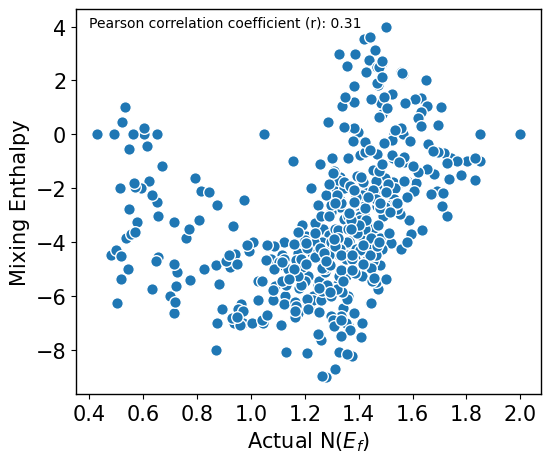

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
fs = 15
plt.scatter(df['N(Ef)'], df['Mixing Enthalpy'], marker='o', c= 'tab:blue', s=70, edgecolor='w')
plt.xlabel(r'Actual N($E_f$)', fontsize=fs)
plt.ylabel('Mixing Enthalpy', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

# Calculate Pearson correlation coefficient

r = np.corrcoef(df['N(Ef)'], df['Mixing Enthalpy'])[0, 1]
# print("Pearson correlation coefficient (r):", r)

# Adjusting spine linewidth
sp=1
ax = plt.gca()
ax.spines['top'].set_linewidth(sp)
ax.spines['right'].set_linewidth(sp)
ax.spines['left'].set_linewidth(sp)
ax.spines['bottom'].set_linewidth(sp)
plt.text(0.4, 4, f'Pearson correlation coefficient (r): {r:.2f}')
plt.show()


This trend suggests a potential correlation between electronic structure and thermodynamic stability—higher N(E<sub>f</sub>) values may be associated with weaker bonding (hence less negative mixing enthalpy), while lower N(E<sub>f</sub>) alloys may exhibit stronger interactions and more stable mixing. However, the spread in the data also highlights the influence of other factors such as atomic size mismatch or entropic contributions.

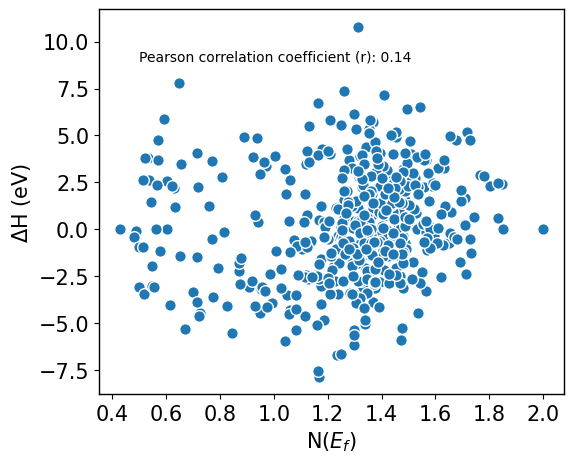

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
fs = 15
plt.scatter(df['N(Ef)'], df['DH (eV)'], marker='o', c= 'tab:blue', s=70, edgecolor='w')
plt.xlabel('N($E_f$)', fontsize=fs)
plt.ylabel('$\Delta$H (eV)', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)


# Calculate Pearson correlation coefficient

r = np.corrcoef(df['N(Ef)'], df['DH (eV)'])[0, 1]
# Adjusting spine linewidth
sp=1
ax = plt.gca()
ax.spines['top'].set_linewidth(sp)
ax.spines['right'].set_linewidth(sp)
ax.spines['left'].set_linewidth(sp)
ax.spines['bottom'].set_linewidth(sp)
plt.text(0.5, 9, f'Pearson correlation coefficient (r): {r:.2f}')

plt.show()


# Train-Test Splitting and Feature Scaling
Now, we split our dataset into training and testing sets using an 80-20 split. This allows us to train the machine learning model on one portion of the data and evaluate its performance on unseen data. We use train_test_split from scikit-learn to ensure a reproducible split with a fixed random_state.

In our case, we found 70:30 to offer a good balance between training accuracy and evaluation reliability

Before training, we also standardize the input features using StandardScaler. Standardization ensures that all features have zero mean and unit variance, which is important for many machine learning algorithms—especially those sensitive to feature scaling such as linear models and neural networks.

The first two rows of the scaled training data are shown below for reference.

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
X_train.head(2)

,Mixing Enthalpy,VEC,Melting Temperature,Pauling Electronegativity,Entropy of Mixing,Radii Difference,Cr,Mo,W,V,Nb,Ta,Ti,Zr,Hf
455,-5.0400,5.10,2776.40,1.7580,11.793273,0.046809,0.0,0.0,30.0,10.0,0.0,40.0,10.0,10.0,0.0
57,-0.4488,5.66,2644.25,2.0458,9.133034,0.017251,0.0,33.0,33.0,34.0,0.0,0.0,0.0,0.0,0.0


## Feature Normalization (Standardization)
Tree-based models (Random Forest, Gradient Boosting, XGBoost) do not require feature normalization, so we apply StandardScaler only to models that benefit from scaling.  
Using Pipelines ensures scaling is applied safely without data leakage and keeps preprocessing consistent during training and deployment.


## Model Selection and Evaluation Setup
In this section, we import a variety of regression models from scikit-learn and XGBoost to evaluate their performance on predicting Young’s modulus. The models include:

**LinearRegression:** A basic linear model for baseline comparison.

**DecisionTreeRegressor:** A non-linear model based on decision trees.

**RandomForestRegressor and GradientBoostingRegressor: Ensemble tree-based models known for strong performance on structured data.

**KNeighborsRegressor:** A distance-based method that predicts based on the closest training samples.

**Support Vector Regressor (SVR):** A kernel-based method that can capture non-linear relationships.

**XGBRegressor:** A high-performance gradient boosting algorithm from the XGBoost library.

To evaluate model performance, we define custom scoring metrics:

**Root Mean Squared Error (RMSE)**

**Mean Absolute Error (MAE)**

Both scorers are wrapped using make_scorer, with greater_is_better=False since lower values indicate better performance.

We define a 10-fold cross-validation strategy using KFold, which randomly splits the dataset into 10 parts, ensuring robust and unbiased model evaluation. The shuffle=True and fixed random_state help maintain reproducibility.

In [38]:
# Baseline model comparison

# --------------------------
# Models that need scaling
# --------------------------

needs_scaling = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet Regression': ElasticNet(),
    'KNN Regressor': KNeighborsRegressor(n_neighbors=10),
    'SVR': SVR(C=100, gamma=0.001, kernel='rbf')
}

# --------------------------
# Models that do NOT need scaling (tree-based / XGBoost)
# --------------------------
no_scaling = {
    'Decision Tree': DecisionTreeRegressor(
        criterion='squared_error',
        min_samples_split=5,
        splitter='best',
        random_state=42
    ),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# unified models dict
models = {}

# Add pipelines for models that require scaling
for name, model in needs_scaling.items():
    models[name] = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

# raw models (no scaling)
for name, model in no_scaling.items():
    models[name] = model

# --------------------------
# Scoring metrics and CV
# --------------------------
scoring_metrics = {
    'r2': make_scorer(r2_score),
    'mae': make_scorer(mean_absolute_error, greater_is_better=False),
    'rmse': make_scorer(root_mean_squared_error, greater_is_better=False)
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

# --------------------------
# Baseline cross-validation
# --------------------------
models_results = []

for name, model in models.items():
    results = {'Model': name}
    print(f"Evaluating baseline model: {name}")

    for metric_name, scorer in scoring_metrics.items():
        scores = cross_val_score(
            model,
            X_train,
            y_train,
            cv=kf,
            scoring=scorer
        )
        results[f'Mean {metric_name.upper()}'] = np.mean(scores)
        results[f'STD {metric_name.upper()}'] = np.std(scores)

    models_results.append(results)

results_df = pd.DataFrame(models_results)
results_df = results_df.sort_values('Mean R2', ascending=False).reset_index(drop=True)

print("\nBaseline model comparison (sorted by Mean R2):")
print(results_df)

results_df.to_csv('base_model_comparison.csv', index=False)


Evaluating baseline model: Linear Regression
Evaluating baseline model: Ridge Regression
Evaluating baseline model: Lasso Regression
Evaluating baseline model: ElasticNet Regression
Evaluating baseline model: KNN Regressor
Evaluating baseline model: SVR
Evaluating baseline model: Decision Tree
Evaluating baseline model: Random Forest
Evaluating baseline model: Gradient Boosting
Evaluating baseline model: XGBoost

Baseline model comparison (sorted by Mean R2):
                   Model   Mean R2    STD R2  Mean MAE   STD MAE  Mean RMSE  \
0      Gradient Boosting  0.953153  0.017197 -0.044814  0.003309  -0.058561   
1                XGBoost  0.942441  0.024914 -0.047458  0.006228  -0.064587   
2          Random Forest  0.939570  0.030556 -0.049231  0.007338  -0.065300   
3                    SVR  0.904194  0.021094 -0.067430  0.007235  -0.085820   
4          KNN Regressor  0.864464  0.020467 -0.074534  0.009890  -0.102875   
5          Decision Tree  0.858704  0.070310 -0.074448  0.0071

## Model Training

.


**Model Evaluation Summary:**

Based on the cross-validation results, the Gradient Boosting Regressor shows the best overall performance with the highest mean R² score and the lowest mean RMSE, closely followed by XGBoost and Random Forest. These three models form the top-performing group and are selected for further fine-tuning to optimize their predictive accuracy.  

In contrast, models like Lasso and ElasticNet exhibit negative R² values, indicating poor fit.


In [39]:
from sklearn.model_selection import GridSearchCV

best_base_models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

param_grids = {
    'Random Forest': {
        'n_estimators': [100, 300, 500],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [2, 3, 4],
        'subsample': [0.8, 1.0]
    },
    'XGBoost': {
        'n_estimators': [200, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'reg_lambda': [1.0, 10.0]
    }
}

tuned_results = []
best_models = {}

for name, model in best_base_models.items():
    print(f"\nTuning {name}...")

    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring=scoring_metrics,  
        refit='r2',
        cv=kf,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    best_models[name] = grid.best_estimator_

    best_idx = grid.best_index_
    cv_res = grid.cv_results_

    tuned_results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'Best Mean R2': cv_res['mean_test_r2'][best_idx],
        'Best Mean MAE': cv_res['mean_test_mae'][best_idx],
        'Best Mean RMSE': cv_res['mean_test_rmse'][best_idx]
    })

tuned_df = pd.DataFrame(tuned_results)

# strip any accidental spaces from column names
tuned_df = tuned_df.rename(columns=lambda c: c.strip())

print("\nTuned models comparison:")
print(tuned_df)

tuned_df.to_csv('tuned_model_comparison.csv', index=False)

# ----- Choose best model by R2 -----
print("\nColumns in tuned_df:", tuned_df.columns.tolist())
print("Models tuned:", list(best_models.keys()))

best_row = tuned_df.sort_values('Best Mean R2', ascending=False).iloc[0]
best_model_name = best_row['Model']
final_best_model = best_models[best_model_name]

print("\nBest model selected based on CV R2:")
print(best_model_name)
print("Best params:", best_row['Best Params'])



Tuning Random Forest...

Tuning Gradient Boosting...

Tuning XGBoost...

Tuned models comparison:
               Model                                        Best Params  \
0      Random Forest  {'max_depth': 20, 'min_samples_leaf': 1, 'min_...   
1  Gradient Boosting  {'learning_rate': 0.05, 'max_depth': 3, 'n_est...   
2            XGBoost  {'colsample_bytree': 0.8, 'learning_rate': 0.0...   

   Best Mean R2  Best Mean MAE  Best Mean RMSE  
0      0.940881      -0.048733       -0.064622  
1      0.956786      -0.042953       -0.055739  
2      0.957863      -0.042586       -0.055790  

Columns in tuned_df: ['Model', 'Best Params', 'Best Mean R2', 'Best Mean MAE', 'Best Mean RMSE']
Models tuned: ['Random Forest', 'Gradient Boosting', 'XGBoost']

Best model selected based on CV R2:
XGBoost
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'reg_lambda': 1.0, 'subsample': 0.8}


## Evaluation on Test data

In [40]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

y_pred = final_best_model.predict(X_test)

test_r2 = r2_score(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = root_mean_squared_error(y_test, y_pred)

print(f"Test R2  : {test_r2:.3f}")
print(f"Test MAE : {test_mae:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")

Test R2  : 0.973
Test MAE : 0.037
Test RMSE: 0.049


**The tuned XGBoost model achieved outstanding performance, reaching an R² of 0.973 with very low MAE (0.037) and RMSE (0.049), indicating excellent generalization and highly accurate predictions.**


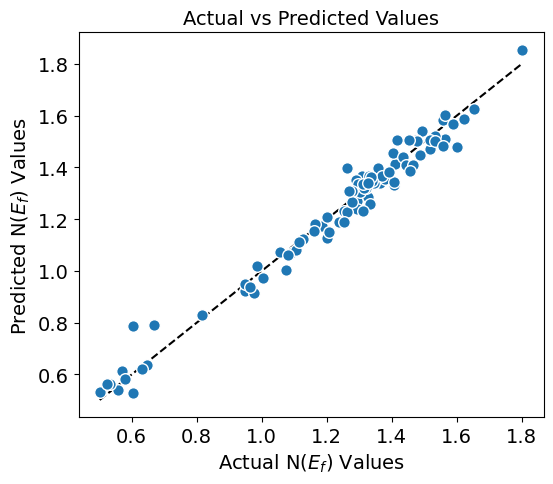

In [41]:
# predictions vs actual
import matplotlib.pyplot as plt
fs=14
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred, marker='o', c= 'tab:blue', s=70, edgecolor='w')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', zorder=0)
plt.xlabel('Actual N($E_f$) Values', fontsize=fs)
plt.ylabel('Predicted N($E_f$) Values', fontsize=fs)
plt.title('Actual vs Predicted Values', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.show()

## Feature Importance using a SHAP (SHapley Additive exPlanations) Summary Plot 

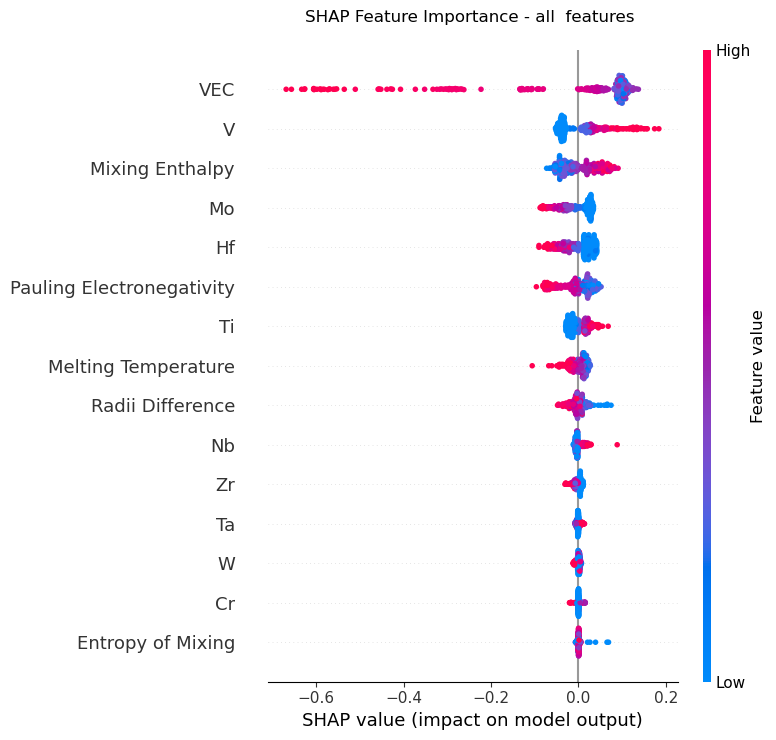

In [42]:
import shap

# Use TreeExplainer for tree-based models like Gradient Boosting
explainer = shap.Explainer(final_best_model, X_train)

# Compute SHAP values
shap_values = explainer(X_train)

plt.title("SHAP Feature Importance - all  features ", pad=20)

# Summary plot
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)


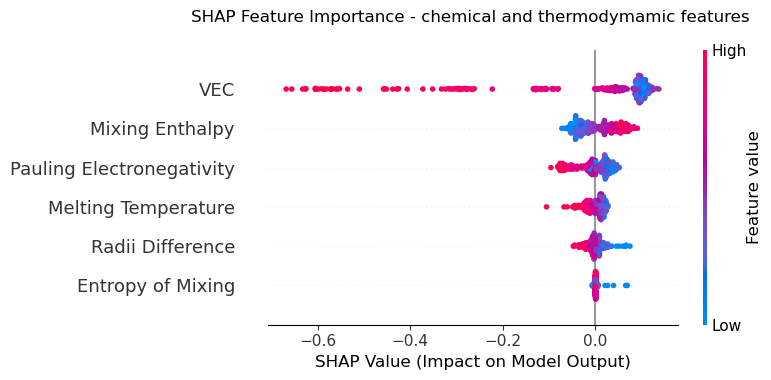

In [43]:

# Define the selected chemical and thermodynamic features
selected_features = ['Mixing Enthalpy', 'VEC', 'Melting Temperature','Radii Difference',
                    'Pauling Electronegativity', 'Entropy of Mixing']

# Create background distribution
background = shap.utils.sample(X_train, 100)  # Use 100 representative samples

# Initialize explainer with the background
explainer = shap.Explainer(final_best_model, background)

# Calculate SHAP values
shap_values = explainer(X_train)

# Filter for selected features
feature_indices = [X_train.columns.get_loc(f) for f in selected_features]
shap_values_selected = shap_values[:, feature_indices]

# Create enhanced summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values.values[:, feature_indices],  # Access the values array directly
    features=X_train[selected_features],
    feature_names=selected_features,
    plot_type="dot",
    show=False
)
plt.title("SHAP Feature Importance - chemical and thermodymamic features ", pad=20)
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)
plt.gcf().tight_layout()
plt.show()



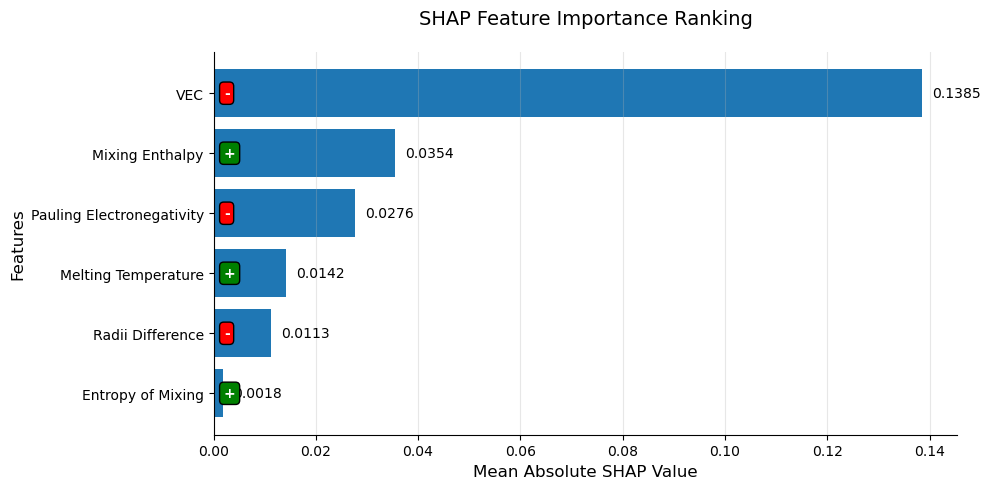

In [44]:

# Get SHAP importance values 
shap_values_array = shap_values.values[:, feature_indices]
mean_abs_shap = np.abs(shap_values_array).mean(axis=0)

# Sort features by importance
sorted_idx = np.argsort(mean_abs_shap)
sorted_features = np.array(selected_features)[sorted_idx]
sorted_importance = mean_abs_shap[sorted_idx]

# Create the plot
plt.figure(figsize=(10, 5))
bars = plt.barh(sorted_features, sorted_importance, color='#1f77b4')

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.002, bar.get_y() + bar.get_height()/2,
             f'{width:.4f}',
             ha='left', va='center')

# Add directional markers
for i, (feature, importance) in enumerate(zip(sorted_features, mean_abs_shap[sorted_idx])):
    direction = '+' if np.mean(shap_values_array[:, sorted_idx[i]]) > 0 else '-'
    plt.text(0.002, i, direction, 
             ha='left', va='center', 
             color='white', weight='bold',
             bbox=dict(facecolor='green' if direction == '+' else 'red', 
                      boxstyle='round,pad=0.3'))

# Formatting
plt.xlabel('Mean Absolute SHAP Value', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('SHAP Feature Importance Ranking', fontsize=14, pad=20)
plt.grid(axis='x', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()

plt.show()

# Save the model

In [45]:
# Save the model
joblib.dump(final_best_model, 'XGB_final_model.pkl')
print('Model saved!')

Model saved!
